In [37]:
# importing all necessary libraries
# dataframe operations
import pandas as pd 
import numpy as np
import datetime
# stat operations
from scipy.stats import mode
#preprocessing
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
# Model selection and hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
# models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
# evaluation metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer

In [38]:
# reading all data files
train = pd.read_csv(r'I:\prml20jslot\train.csv')
test  = pd.read_csv(r'I:\prml20jslot\test.csv')
remarks = pd.read_csv(r'I:\prml20jslot\remarks.csv')
remarks_supp_opp = pd.read_csv(r'I:\prml20jslot\remarks_supp_opp.csv')
ratings = pd.read_csv(r'I:\prml20jslot\ratings.csv')

## EDA

In [39]:
remarks.head()

,emp,comp,remarkId,txt,remarkDate
0,307,bnivzbfi,fvwadfrj,**********************************************...,20-03-2017
1,382,bnivzbfi,xrrfkgap,*****************************,20-03-2017
2,172,bnivzbfi,xkcrccwi,***************************,20-03-2017
3,135,bnivzbfi,lohhvtmo,***************************,20-03-2017
4,225,bnivzbfi,gpxxmoab,*********************************,20-03-2017


In [40]:
remarks.isnull().sum()

emp             0
comp            0
remarkId        0
txt           217
remarkDate      1
dtype: int64

## FEATURE ENGINEERING

In [41]:
def unique_id(df):
    """
    Creates a unique id for a employee, (emp,comp) 
    """
    el = df['emp'].tolist()
    cl = df['comp'].tolist()
    tup = tuple(zip(el,cl))
    df['unique_id'] = tup
    df['unique_id'] = df['unique_id'].astype(str)
    return df

def remark_length(s):
    """
    returns length of the remark string
    """
    n = len(s)
    return n

#cleaning remarks dataframe
def clean_remarks(remarks):
    
    remarks = remarks[remarks['emp'] > 0] #droping negative emp rows
    # remarks = remarks.drop(remarks[remarks['txt'].isnull()].index) #null remarks are dropped
    remarks['txt'] = remarks['txt'].fillna('')  #null remarks are filled with 0
    remarks['length'] = remarks['txt'].apply(remark_length) # adding column of remark length
    remarks.drop('txt',axis=1,inplace=True)
    remarks = unique_id(remarks)

    return remarks


#cleaning remarks_supp_opp

def clean_remarks_supp_opp(remarks_supp_opp):
    
    remarks_supp_opp = remarks_supp_opp[remarks_supp_opp['emp'] > 0] #droping negative emp rows
    remarks_supp_opp.drop('oppose',axis=1,inplace=True)   #oppose and support convey same info
    remarks_supp_opp = remarks_supp_opp[remarks_supp_opp['remarkId'].isin(remarks['remarkId'].unique())] 
    #dropping rows which give support info for remarks that are not listed in the remarks file
    remarks_supp_opp['support'] = le.fit_transform(remarks_supp_opp['support'] )
    remarks_supp_opp=remarks_supp_opp.replace(to_replace=0 , value = -1)
    remarks_supp_opp = unique_id(remarks_supp_opp)

    return remarks_supp_opp



#calculates how much support a remark got from other employees

def support_factor(g,remarks):
    """
    calculates how much support a remark got from other employees
    """
    remarkid_g = g.index.tolist()
    sf = g['support'].tolist()
    d = dict(zip(remarkid_g,sf))
    remarkid_remarks = remarks['remarkId'].tolist()
    sup=[]
    for r in remarkid_remarks:
        if r in remarkid_g:
            sup.append(d[r])
        else:
            sup.append(0)
    
    return sup

def extract_time_remarks(df):
    df = df.drop(df[df['remarkDate'].isnull()].index)
    df['remarkDate'] = pd.to_datetime(df.remarkDate, dayfirst=True)
    df['since_last_remark'] = df['remarkDate'].max() - df['remarkDate']
    df['since_last_remark'] = df['since_last_remark'].astype('timedelta64[D]')
    df['remark_month']  = df['remarkDate'].dt.month
    df['remark_weekday']  = df['remarkDate'].dt.dayofweek
    df['remark_day']  = df['remarkDate'].dt.day
    return df 


#feature engineering remarks
def feature_engineer_remarks(remarks,remarks_supp_opp):
    
    g = remarks_supp_opp.groupby('remarkId').mean()
    s_ = support_factor(g,remarks)
    remarks['support_factor'] = s_
    remarks = extract_time_remarks(remarks)
    return remarks

In [42]:
# cleaning remarks dataframe
remarks = clean_remarks(remarks)

In [43]:
# creating inique id for each file
train = unique_id(train)
ratings = unique_id(ratings)
test = unique_id(test)

In [44]:
#cleaning remarks_supp_opp data frame
remarks_supp_opp = clean_remarks_supp_opp(remarks_supp_opp)

In [45]:
# full feature engineering for remarks. adds "support_factor" column
remarks = feature_engineer_remarks(remarks,remarks_supp_opp)

In [46]:
remarks.head()

,emp,comp,remarkId,remarkDate,length,unique_id,support_factor,since_last_remark,remark_month,remark_weekday,remark_day
0,307,bnivzbfi,fvwadfrj,2017-03-20,62,"(307, 'bnivzbfi')",1.000000,0.0,3,0,20
1,382,bnivzbfi,xrrfkgap,2017-03-20,29,"(382, 'bnivzbfi')",-0.333333,0.0,3,0,20
2,172,bnivzbfi,xkcrccwi,2017-03-20,27,"(172, 'bnivzbfi')",1.000000,0.0,3,0,20
3,135,bnivzbfi,lohhvtmo,2017-03-20,27,"(135, 'bnivzbfi')",0.000000,0.0,3,0,20
4,225,bnivzbfi,gpxxmoab,2017-03-20,33,"(225, 'bnivzbfi')",0.200000,0.0,3,0,20


In [47]:
#calculates average rating made by an employee

def avg_rating(g_,train):
    train_unique = train['unique_id'].tolist()
    rating =   g_['rating'].tolist()
    g_unique = g_.index.tolist()
    d = dict(zip(g_unique,rating))
    avg_rate =[]
    for u in train_unique:
        if u in g_unique:
            avg_rate.append(d[u])
        else:
            avg_rate.append(0)
    return avg_rate

num_ratings = list(ratings.groupby('unique_id').count()['rating'])

# number of ratings
def num_rating(g_,train):
    train_unique = train['unique_id'].tolist()
    rating =   g_['rating'].tolist()
    g_unique = g_.index.tolist()
    d = dict(zip(g_unique,rating))
    num_rate =[]
    for u in train_unique:
        if u in g_unique:
            num_rate.append(d[u])
        else:
            num_rate.append(0)
    return num_rate

# median of ratings

def med_rating(g_,train):
    train_unique = train['unique_id'].tolist()
    rating =   g_['rating'].tolist()
    g_unique = g_.index.tolist()
    d = dict(zip(g_unique,rating))
    med_rate =[]
    for u in train_unique:
        if u in g_unique:
            med_rate.append(d[u])
        else:
            med_rate.append(0)
    return med_rate

# number of ratings for a company
def num_comp_ratings(g_,train):
    l = []
    for c in train['comp']:
        l.append(g_.loc[c]['rating'])
    return l

# average rating for a company
def avg_comp_rating(g_, train):
    l = []
    for c in train['comp']:
        l.append(g_.loc[c]['rating'])
    return l 

#median rating for a company
def med_comp_rating(g_, train):
    l = []
    for c in train['comp']:
        l.append(g_.loc[c]['rating'])
    return l 

#feature engineering ratings

def feature_engineer_ratings(ratings,train):

    g = ratings.groupby('unique_id').mean()
    a = avg_rating(g,train)
    train['avg_rating'] = a

    g = ratings.groupby('unique_id').count()
    a = num_rating(g,train)
    train['num_ratings'] = a

    g = ratings.groupby('unique_id').median()
    a = med_rating(g,train)
    train['median_ratings'] = a

    g = ratings.groupby('comp').count()
    a = num_comp_ratings(g,train)
    train['num_ratings_comp'] = a

    g = ratings.groupby('comp').mean()
    a = avg_comp_rating(g, train)
    train['avg_company_rating'] = a

    g = ratings.groupby('comp').median()
    a = med_comp_rating(g, train)
    train['median_company_rating'] = a

    return train

# extract features from time

def extract_time(nt):
    
    nt['lastratingdate'] = pd.to_datetime(nt['lastratingdate'], dayfirst=True)
    nt['since_lastrating'] = pd.to_datetime('2017-03-20 00:00:00') - nt['lastratingdate']
    nt['since_lastrating'] = nt['since_lastrating'].astype('timedelta64[D]')
    nt['rating_month']  = nt['lastratingdate'].dt.month 
    nt['rating_weekday']  = nt['lastratingdate'].dt.dayofweek 
    nt['rating_year']  = nt['lastratingdate'].dt.year 
    nt['rating_day']  = nt['lastratingdate'].dt.day
    nt['dayofweek_name'] = nt['lastratingdate'].dt.day_name()
    nt['is_weekend'] = np.where(nt['dayofweek_name'].isin(['Sunday','Saturday']),1,0)
    nt['rating_quarter'] = nt['lastratingdate'].dt.quarter
    return nt

# feature engineer train further

def feature_engg(remarks,ratings,train):
   
    train = feature_engineer_ratings(ratings,train)

    train_unique = train['unique_id'].tolist()

    g = remarks.groupby('unique_id').mean()
    uniqueid_g = g.index.tolist()

    sf = g['support_factor'].tolist()
    avg_len = g['length'].tolist()
    avg_days_since_last_remark = g['since_last_remark'].tolist()

    d1 = dict(zip(uniqueid_g,sf))
    d2 = dict(zip(uniqueid_g,avg_len))
    d3 = dict(zip(uniqueid_g,avg_days_since_last_remark))
    
    al =[]
    sf_ = []
    adsl = []
    
    g1 = remarks.groupby('unique_id').count()
    nr = g1['remarkId'].tolist()
    d4 = dict(zip(uniqueid_g,nr))
    
    num_rem = []

    g2 = remarks.groupby('unique_id')
    slr = list(g2.since_last_remark.min())
    sfr = list(g2.since_last_remark.max())
    madr = list(g2.since_last_remark.mad())

    sila = []
    sifi = []
    mea = []

    d5 = dict(zip(uniqueid_g,slr))
    d6 = dict(zip(uniqueid_g,sfr))
    d7 = dict(zip(uniqueid_g,madr))

    for u in train_unique:
        if u in uniqueid_g:
            sf_.append(d1[u])
            al.append(d2[u]) 
            adsl.append(d3[u])
            num_rem.append(d4[u])
            sila.append(d5[u])
            sifi.append(d6[u])
            mea.append(d7[u])
        else:
            sf_.append(0)
            al.append(0)
            adsl.append(0)
            num_rem.append(0)
            sila.append(0)
            sifi.append(0)
            mea.append(0)

    train['avg_remark_length'] = al
    train['avg_support_factor'] = sf_
    train['avg_days_since_last_remark'] = adsl
    train['number_remarks'] = num_rem
    train['since_last_remark'] = sila 
    train['since_first_remark'] = sifi
    train['mean_abs_diff_remarkfreq'] = mea
    
    train = extract_time(train)

    return train

def PolynomialFeatures_labeled(input_df,power):
    '''Basically this is a cover for the sklearn preprocessing function. 
    The problem with that function is if you give it a labeled dataframe, it ouputs an unlabeled dataframe with potentially
    a whole bunch of unlabeled columns. 

    Inputs:
    input_df = Your labeled pandas dataframe (list of x's not raised to any power) 
    power = what order polynomial you want variables up to. (use the same power as you want entered into pp.PolynomialFeatures(power) directly)

    Ouput:
    Output: This function relies on the powers_ matrix which is one of the preprocessing function's outputs to create logical labels and 
    outputs a labeled pandas dataframe   
    '''
    poly = PolynomialFeatures(power, interaction_only=True)
    output_nparray = poly.fit_transform(input_df)
    powers_nparray = poly.powers_

    input_feature_names = list(input_df.columns)
    target_feature_names = ["Constant Term"]
    for feature_distillation in powers_nparray[1:]:
        intermediary_label = ""
        final_label = ""
        for i in range(len(input_feature_names)):
            if feature_distillation[i] == 0:
                continue
            else:
                variable = input_feature_names[i]
                power = feature_distillation[i]
                intermediary_label = "%s" % (variable)
                if final_label == "":         #If the final label isn't yet specified
                    final_label = intermediary_label
                else:
                    final_label = final_label + " x " + intermediary_label
        target_feature_names.append(final_label)
    output_df = pd.DataFrame(output_nparray, columns = target_feature_names)
    output_df.drop(columns="Constant Term", inplace= True)
    return output_df

In [48]:
# initial feature engineering for train and test (not adding polynomial features now)
train = feature_engg(remarks,ratings,train)
test  = feature_engg(remarks,ratings,test)

In [49]:
train.head().transpose()

,0,1,2,3,4
id,2228,4349,945,4553,941
emp,939,250,134,164,129
comp,phcvroct,jblrepyr,ewpvmfbc,wsmblohy,ewpvmfbc
lastratingdate,2016-10-17 00:00:00,2017-03-19 00:00:00,2016-09-21 00:00:00,2017-03-17 00:00:00,2016-04-04 00:00:00
left,1,0,0,0,0
unique_id,"(939, 'phcvroct')","(250, 'jblrepyr')","(134, 'ewpvmfbc')","(164, 'wsmblohy')","(129, 'ewpvmfbc')"
avg_rating,3,3.76786,2.92308,2.41176,2.8
num_ratings,1,112,26,17,5
median_ratings,3,4,3,2,3
num_ratings_comp,50479,5497,3602,3648,3602


## Feature Selection

In [50]:
# dropping some columns that are redundant
train.drop('unique_id', axis=1, inplace=True)
test.drop('unique_id', axis =1 , inplace= True)

train.drop('lastratingdate',axis=1, inplace=True)
test.drop('lastratingdate',axis=1, inplace=True)

train.drop('dayofweek_name',axis=1, inplace=True)
test.drop('dayofweek_name',axis=1, inplace=True)

train.drop('rating_year', axis=1, inplace =True)
test.drop('rating_year', axis=1,inplace = True)

# label encoding "company"
train['comp'] = le.fit_transform(train['comp'])
test['comp'] = le.transform(test['comp'])

In [51]:
## for feature importance calculation

from  eda_selection_utility import * 
def lgbm_importance2(df, target=None, scale_pos_weight=1, ascending=True):
    cols = df.drop([target], axis=1).columns.tolist()
    y = df[target].values
    X = df.drop([target], axis=1).values
    
    model = LGBMClassifier(n_estimators=200,
                           learning_rate=0.05,
                           max_depth=4,
                           objective='binary',
                           scale_pos_weight=scale_pos_weight,
                           random_state=123)
    model.fit(X, y)
    f_imps = model.feature_importances_
    
    # Plot importances
    table = pd.DataFrame({'Column': cols, 'Importance': f_imps})
    table = table.sort_values(by='Importance', ascending=ascending)
    table = table.set_index(table['Column'])
    
    plt.figure(figsize=(20,20))
    table['Importance'].plot.barh()
    plt.title('Feature Importance')
    plt.grid()
    plt.show()

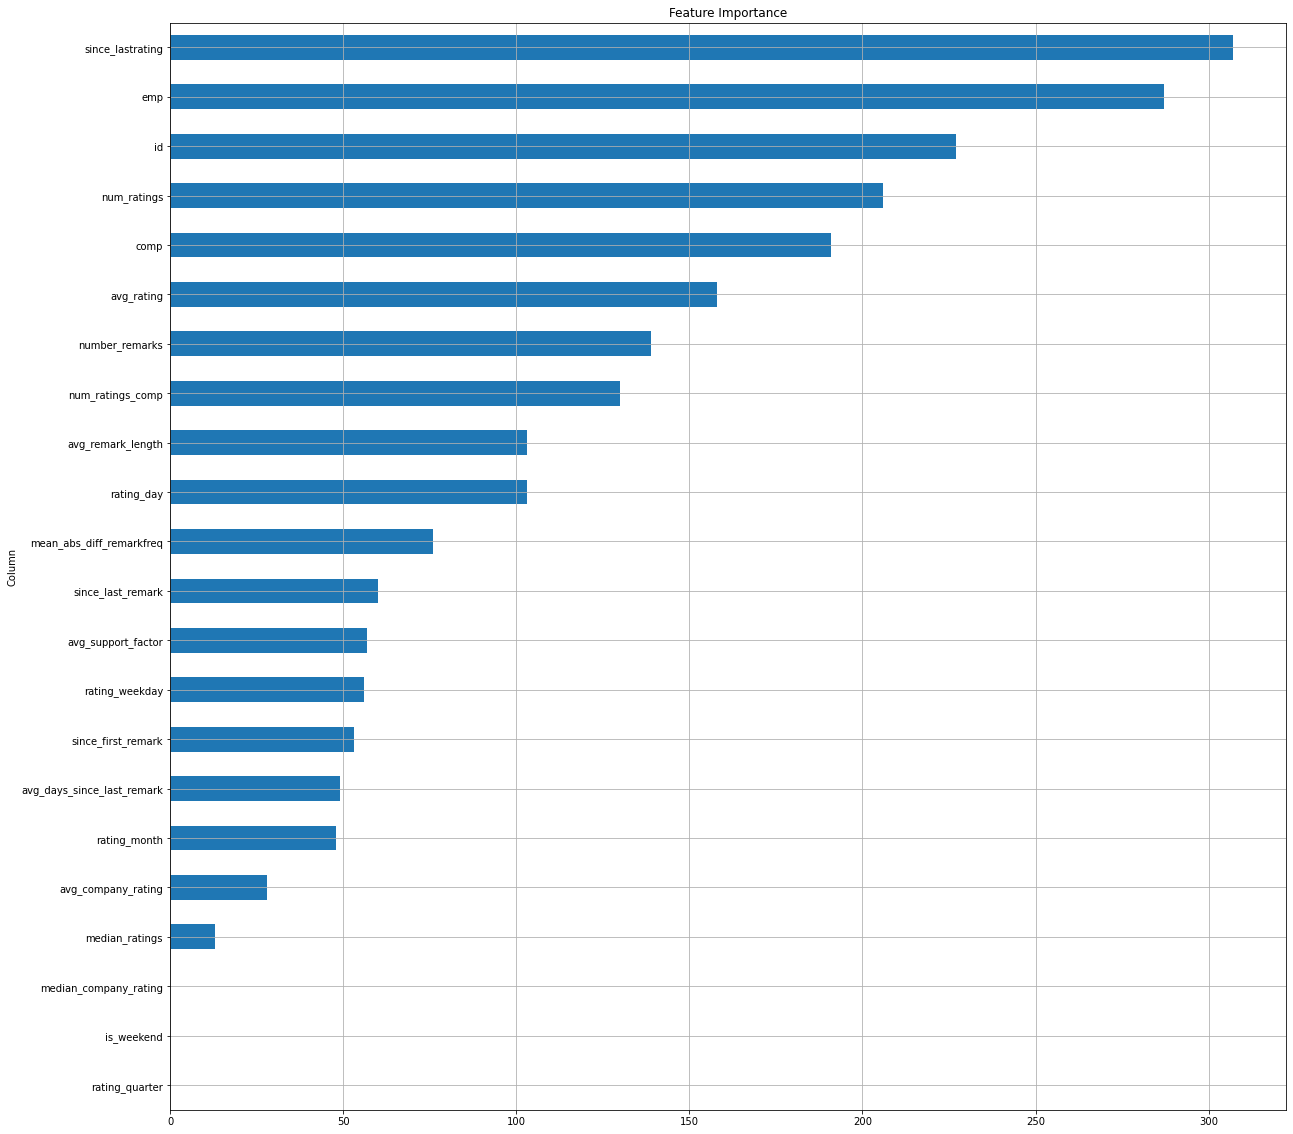

In [52]:
lgbm_importance2(train, 'left', ascending=True)

Note that 'median_company_rating', 'is_weekend', 'rating_quarter' has 0 feature importance.

In [53]:
train.drop('median_company_rating', axis=1, inplace=True)
test.drop('median_company_rating', axis =1 , inplace= True)

train.drop('is_weekend',axis=1, inplace=True)
test.drop('is_weekend',axis=1, inplace=True)

train.drop('rating_quarter',axis=1, inplace=True)
test.drop('rating_quarter',axis=1, inplace=True)

### Adding PolynomialFeatures

In [54]:
num = train.drop(['comp', 'left','rating_month','rating_weekday','rating_day','id','emp'], axis = 1)
numengg = PolynomialFeatures_labeled(num,2)

In [55]:
numengg.head()

,avg_rating,num_ratings,median_ratings,num_ratings_comp,avg_company_rating,avg_remark_length,avg_support_factor,avg_days_since_last_remark,number_remarks,since_last_remark,...,number_remarks x since_last_remark,number_remarks x since_first_remark,number_remarks x mean_abs_diff_remarkfreq,number_remarks x since_lastrating,since_last_remark x since_first_remark,since_last_remark x mean_abs_diff_remarkfreq,since_last_remark x since_lastrating,since_first_remark x mean_abs_diff_remarkfreq,since_first_remark x since_lastrating,mean_abs_diff_remarkfreq x since_lastrating
0,3.000000,1.0,3.0,50479.0,2.591810,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000
1,3.767857,112.0,4.0,5497.0,3.028743,136.326923,0.838002,130.596154,104.0,6.0,...,624.0,17472.0,2698.153846,104.0,1008.0,155.662722,6.0,4358.556213,168.0,25.943787
2,2.923077,26.0,3.0,3602.0,2.643531,45.800000,0.600000,280.600000,10.0,195.0,...,1950.0,3630.0,440.800000,1800.0,70785.0,8595.600000,35100.0,16001.040000,65340.0,7934.400000
3,2.411765,17.0,2.0,3648.0,2.763706,21.200000,-0.119298,12.400000,10.0,3.0,...,30.0,240.0,72.800000,30.0,72.0,21.840000,9.0,174.720000,72.0,21.840000
4,2.800000,5.0,3.0,3602.0,2.643531,75.000000,1.000000,391.500000,4.0,371.0,...,1484.0,1648.0,82.000000,1400.0,152852.0,7605.500000,129850.0,8446.000000,144200.0,7175.000000


In [56]:
numengg['comp'] = train['comp'].copy()
numengg['id'] = train['id'].copy()
numengg['emp'] = train['emp'].copy()
numengg['rating_month'] = train['rating_month'].copy()
numengg['rating_day'] = train['rating_day'].copy()
numengg['rating_weekday'] = train['rating_weekday'].copy()

In [57]:
y_train = train['left']

In [58]:
train = numengg.copy()
train['left'] = y_train

In [59]:
numt = test.drop(['comp','rating_month','rating_weekday','rating_day','id','emp'], axis = 1)
numenggt = PolynomialFeatures_labeled(numt,2)

numenggt['comp'] = test['comp'].copy()
numenggt['id'] = test['id'].copy()
numenggt['emp'] = test['emp'].copy()
numenggt['rating_month'] = test['rating_month'].copy()
numenggt['rating_day'] = test['rating_day'].copy()
numenggt['rating_weekday'] = test['rating_weekday'].copy()
test = numenggt.copy()

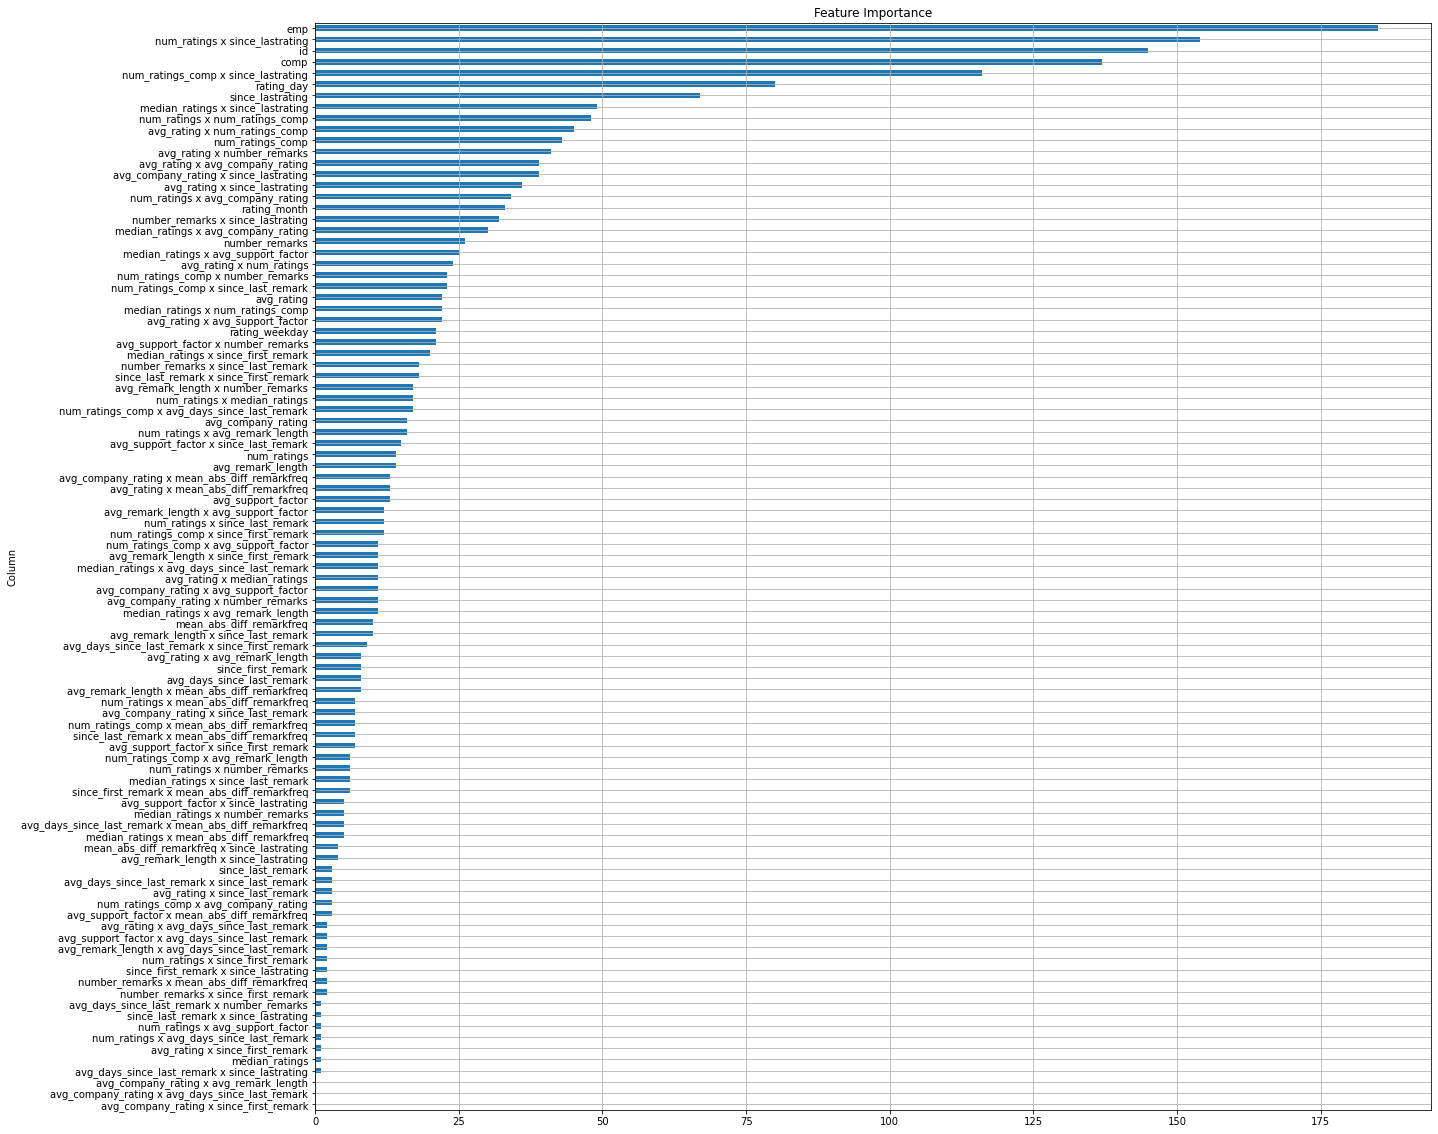

In [60]:
lgbm_importance2(train, 'left', ascending=True)

In [64]:
to_drop = ['avg_company_rating x avg_remark_length',
'median_ratings', 
'num_ratings x avg_support_factor',
'avg_company_rating x since_last_remark',
'avg_company_rating x since_first_remark',
'avg_days_since_last_remark x number_remarks',
'num_ratings x avg_days_since_last_remark',
'since_last_remark x since_lastrating',
'avg_rating x since_lastrating',
'num_ratings_comp x since_first_remark',
'num_ratings_comp x mean_abs_diff_remarkfreq']

In [66]:
train.drop(to_drop, axis=1, inplace=True)
test.drop(to_drop, axis=1, inplace=True)

In [67]:
train.head()

,avg_rating,num_ratings,num_ratings_comp,avg_company_rating,avg_remark_length,avg_support_factor,avg_days_since_last_remark,number_remarks,since_last_remark,since_first_remark,...,since_first_remark x mean_abs_diff_remarkfreq,since_first_remark x since_lastrating,mean_abs_diff_remarkfreq x since_lastrating,comp,id,emp,rating_month,rating_day,rating_weekday,left
0,3.000000,1.0,50479.0,2.591810,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,20,2228,939,10,17,0,1
1,3.767857,112.0,5497.0,3.028743,136.326923,0.838002,130.596154,104.0,6.0,168.0,...,4358.556213,168.0,25.943787,10,4349,250,3,19,6,0
2,2.923077,26.0,3602.0,2.643531,45.800000,0.600000,280.600000,10.0,195.0,363.0,...,16001.040000,65340.0,7934.400000,6,945,134,9,21,2,0
3,2.411765,17.0,3648.0,2.763706,21.200000,-0.119298,12.400000,10.0,3.0,24.0,...,174.720000,72.0,21.840000,31,4553,164,3,17,4,0
4,2.800000,5.0,3602.0,2.643531,75.000000,1.000000,391.500000,4.0,371.0,412.0,...,8446.000000,144200.0,7175.000000,6,941,129,4,4,0,0


In [68]:
test.head()

,avg_rating,num_ratings,num_ratings_comp,avg_company_rating,avg_remark_length,avg_support_factor,avg_days_since_last_remark,number_remarks,since_last_remark,since_first_remark,...,since_last_remark x mean_abs_diff_remarkfreq,since_first_remark x mean_abs_diff_remarkfreq,since_first_remark x since_lastrating,mean_abs_diff_remarkfreq x since_lastrating,comp,id,emp,rating_month,rating_day,rating_weekday
0,4.000000,43.0,26756.0,3.236470,86.0,0.960784,20.0,6.0,3.0,39.0,...,38.00,494.00,0.0,0.00,2,353,509,3,20,0
1,2.130435,69.0,6450.0,2.855814,43.8,0.933333,149.4,10.0,81.0,168.0,...,2216.16,4596.48,504.0,82.08,15,732,22,3,17,4
2,2.444444,18.0,16886.0,2.633187,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.00,0.00,0.0,0.00,25,3076,2,1,9,0
3,2.831325,83.0,50479.0,2.591810,67.5,0.500000,234.5,4.0,227.0,242.0,...,1702.50,1815.00,41140.0,1275.00,20,2199,885,10,1,5
4,2.111111,9.0,50479.0,2.591810,78.0,0.000000,48.0,2.0,48.0,48.0,...,0.00,0.00,2016.0,0.00,20,2145,756,2,6,0


## Modeling

In [70]:
X_train = train.drop('left', axis =1)
y_train = train['left'].copy()

In [73]:
# weighted accuracy score, to be used for cross validation
def wacc_score(y_true, y_pred): 
    return((((y_true==y_pred)*(y_true*4+1)).sum())/((y_true*4+1).sum()))

In [77]:
yt = np.array([1,0,0,0,1])
yp = np.array([0,0,0,1,1])
wacc_score(yt, yp)

0.5384615384615384

In [79]:
# random search for approximate best hyperparameters
scoring = {
    'Weighted_Accuracy': make_scorer(wacc_score)
}

params = {
    'scale_pos_weight': range(5, 7),
    'colsample_bytree': range(0, 5),
    'max_depth': range(2, 20, 2),
    'n_estimators': range(200, 400, 50),
    'reg_lambda': range(0,4),
    'subsample': range(0,4)
}

clf = XGBClassifier(random_state = 42)
rdm_clf = RandomizedSearchCV(clf, n_iter = 100, verbose = 2, cv = 3,
                             param_distributions = params, scoring=scoring,refit='Weighted_Accuracy',n_jobs = -1)

In [80]:
rdm_clf.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   26.4s finished


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                           subsample=None, tree_method=None,
                                           validate_parameters=None,
                                   

In [82]:
rdm_results = pd.DataFrame(rdm_clf.cv_results_)

In [84]:
rdm_results_top3 = rdm_results.nsmallest(3, 'rank_test_Weighted_Accuracy')

In [88]:
 rdm_results_top3[[
    'param_scale_pos_weight', 'param_colsample_bytree','param_n_estimators', 'param_reg_lambda','param_subsample',
    'param_max_depth', 'mean_test_Weighted_Accuracy', 'std_test_Weighted_Accuracy', 'rank_test_Weighted_Accuracy'
]]

,param_scale_pos_weight,param_colsample_bytree,param_n_estimators,param_reg_lambda,param_subsample,param_max_depth,mean_test_Weighted_Accuracy,std_test_Weighted_Accuracy,rank_test_Weighted_Accuracy
63,5,1,200,3,1,2,0.866657,0.010753,1
42,6,0,200,3,1,2,0.845643,0.013520,2
64,6,0,300,2,1,2,0.845643,0.013935,3


In [89]:
# Create the grid search parameter grid and scoring funcitons
param_grid = {"learning_rate":[0.1,0.05,0.03],"colsample_bytree": [0.2,0.4,0.7,0.9],"subsample": [0.7,0.8,1],
    "max_depth": [2,3,4,5],
    "n_estimators": [200,270,300],
    "reg_lambda": [1.2,2.2,2.7,3],
    "scale_pos_weight":[5,6]}

In [91]:
# create the Kfold object

num_folds = 5
kfold = StratifiedKFold(n_splits=num_folds, random_state=42)
model = XGBClassifier(random_state=42)

# create the grid search object

grid = GridSearchCV(
    estimator=model, 
    param_grid=param_grid,
    cv=kfold,
    scoring=scoring,
    n_jobs=-1,
    refit='Weighted_Accuracy'
)
# fit grid search
%time best_model = grid.fit(X_train,y_train)

Wall time: 2h 25s


In [92]:
grid.best_params_ 

{'colsample_bytree': 0.9,
 'learning_rate': 0.1,
 'max_depth': 2,
 'n_estimators': 270,
 'reg_lambda': 2.7,
 'scale_pos_weight': 6,
 'subsample': 1}

In [93]:
grid_results = pd.DataFrame(grid.cv_results_)

In [95]:
grid_results_top3 = grid_results.nsmallest(3, 'rank_test_Weighted_Accuracy')

In [96]:
 grid_results_top3[[
    'param_scale_pos_weight', 'param_colsample_bytree','param_n_estimators', 'param_reg_lambda','param_subsample',
    'param_max_depth', 'mean_test_Weighted_Accuracy', 'std_test_Weighted_Accuracy', 'rank_test_Weighted_Accuracy'
]]

,param_scale_pos_weight,param_colsample_bytree,param_n_estimators,param_reg_lambda,param_subsample,param_max_depth,mean_test_Weighted_Accuracy,std_test_Weighted_Accuracy,rank_test_Weighted_Accuracy
2633,6,0.9,270,2.7,1,2,0.886635,0.016077,1
3005,6,0.9,300,1.2,1,3,0.886457,0.022318,2
1793,6,0.7,300,2.7,1,2,0.885276,0.019320,3


In [106]:
# xgb = XGBClassifier(scale_pos_weight = 5,colsample_bytree = 0.7, max_depth= 2,n_estimators= 250,reg_lambda=1.2,subsample=0.8)
xgb = XGBClassifier(scale_pos_weight = 5,colsample_bytree = 0.7, max_depth= 2,n_estimators= 200,reg_lambda=1.2,subsample=0.8)
# xgb = XGBClassifier(scale_pos_weight = 6,colsample_bytree = 0.9, max_depth= 2,n_estimators= 270,reg_lambda=2.7,subsample=1)

In [107]:
xgb.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1.2, scale_pos_weight=5, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [108]:
yxgb = xgb.predict(test)
sub = pd.DataFrame()
sub['id'] = test['id']
sub['left'] = yxgb
sub.to_csv('pred.csv', index=False)